In [5]:
#!pip install dbfread

In [1]:
import pandas as pd
from dbfread import DBF

df_list = []

for i in range(10, 23):
    file = DBF(f'data/DOPB20{i}.dbf', load=True)
    print(file)
    df = pd.DataFrame(file)
    df_list.append(df)

<loaded DBF table 'data/DOPB2010.dbf'>
<loaded DBF table 'data/DOPB2011.dbf'>
<loaded DBF table 'data/DOPB2012.dbf'>
<loaded DBF table 'data/DOPB2013.dbf'>
<loaded DBF table 'data/DOPB2014.dbf'>
<loaded DBF table 'data/DOPB2015.dbf'>
<loaded DBF table 'data/DOPB2016.dbf'>
<loaded DBF table 'data/DOPB2017.dbf'>
<loaded DBF table 'data/DOPB2018.dbf'>
<loaded DBF table 'data/DOPB2019.dbf'>
<loaded DBF table 'data/DOPB2020.dbf'>
<loaded DBF table 'data/DOPB2021.dbf'>
<loaded DBF table 'data/DOPB2022.dbf'>


In [2]:
df_concat = pd.DataFrame()

for df in df_list:
    df_concat = pd.concat([df_concat, df])

len(df_list)

13

In [3]:
from numpy import nan

columns = ['DTOBITO','CONTADOR','OCUP', 'HORAOBITO','NATURAL','CODMUNNATU','DTNASC','IDADE','SEXO','RACACOR','ESTCIV','ESC2010','CODMUNRES','LOCOCOR','CODMUNOCOR','CIRCOBITO','FONTE', 'TIPOBITO']

df_hom = (df_concat
 .filter(columns)
 .drop_duplicates()
 .replace('', nan)
 .query('CIRCOBITO == "3"')
 .query('TIPOBITO == "2"')
 .astype({'ESC2010': float})
 .reset_index().drop('index', axis=1)
)

df_hom['DTOBITO'] = df_hom['DTOBITO'].apply(lambda x: x[-4:])

In [4]:
qtd_linhas = df_concat.shape[0]

(df_hom
 .query('ESC2010 == 9').shape[0] # possivel limitação devido ao 9 == ignorado
)

4353

In [5]:
(df_hom
 .groupby('ESC2010', dropna=False)['CONTADOR'].count()
 #.apply(lambda x: (x/qtd_linhas) * 100).sum()
)

ESC2010
0.0     335
1.0    2009
2.0    1319
3.0     505
4.0      43
5.0      85
9.0    4353
NaN    8189
Name: CONTADOR, dtype: int64

<Axes: xlabel='LOCOCOR'>

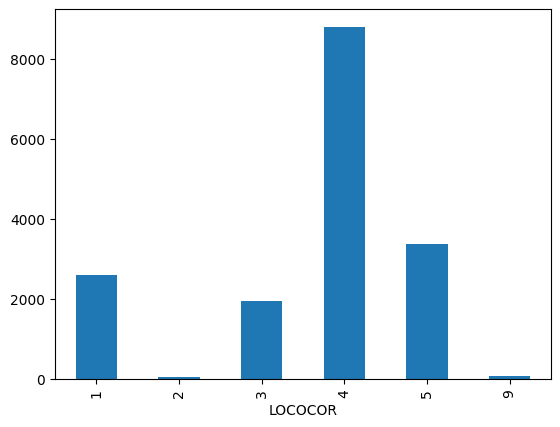

In [6]:
df_hom.groupby('LOCOCOR')['CONTADOR'].count().plot(kind='bar') # 4 - via pública é o maior

In [7]:
df_hom.groupby('FONTE', dropna=False)['CONTADOR'].count()#.plot(kind='bar')#.sum()

FONTE
1      11530
2         61
3         18
4        118
9        151
NaN     4960
Name: CONTADOR, dtype: int64

In [8]:
(df_hom
 .reset_index()
 .drop('index', axis=1)
 .query("IDADE.str.startswith('4') == False")
 .groupby('IDADE')['CONTADOR'].count().sum()
) # 54 não tem idade definida (indigente ou cpf perdido...)

np.int64(54)

In [9]:
#df_hom.query("NATURAL.str.startswith('8') and NATURAL != '999' and NATURAL.str.endswith('25') == False")#.groupby('NATURAL')['CONTADOR'].count()

<Axes: xlabel='ESC2010'>

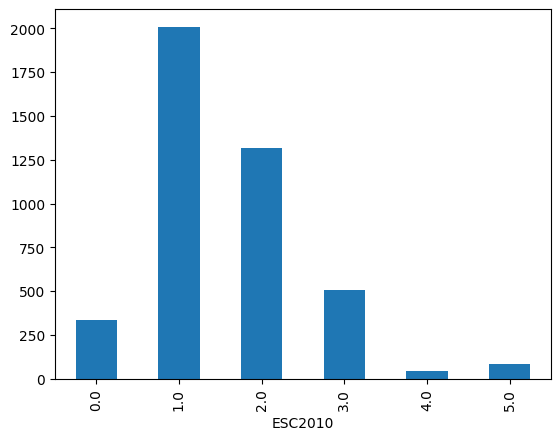

In [10]:
df_hom.groupby('ESC2010')['CONTADOR'].count().drop(9).plot(kind='bar')

In [11]:
df_hom.groupby('DTOBITO')['CONTADOR'].count()

DTOBITO
2010    1364
2011    1555
2012    1460
2013    1511
2014    1521
2015    1487
2016    1301
2017    1314
2018    1201
2019     861
2020    1092
2021    1099
2022    1072
Name: CONTADOR, dtype: int64

# Leitura dos dados das populações

In [13]:
pop0120 = pd.read_excel('data/pop0120.xls', header=4).iloc[15].drop('Unidades da Federação').astype(int)
pop0120

2001    3468594
2002    3494893
2003    3518595
2004    3568350
2005    3595886
2006    3623215
2007    3641397
2008    3742606
2009    3769977
2010    3766834
2011    3791315
2012    3815171
2013    3914421
2014    3943885
2015    3972202
2016    3999415
2017    4025558
2018    3996496
2019    4018127
2020    4039277
Name: 15, dtype: int64

In [14]:
pop2021 = (pd.read_excel('data/pop2021.xls').iloc[15].rename({'Unnamed: 2': '2021'})
.drop(['ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2021', 'Unnamed: 1'])).astype(int)
pop2021

2021    4059905
Name: 15, dtype: int64

In [16]:
pop2022 = pd.read_excel('data/pop2022.xlsx', header=2).drop('Unnamed: 0', axis=1).dropna(subset='COD. UF').query('UF == "PB"').groupby('UF')['POP. TOTAL'].sum().rename({'PB': 2022}).astype(int)
pop2022

UF
2022    3974687
Name: POP. TOTAL, dtype: int64

# Juntando dados IBGE com SIM

In [17]:
pop = pd.concat([pop0120, pop2021, pop2022])
pop = pop.reset_index().rename(columns={'index': 'DTOBITO',0: 'POPULACAO'}).drop(range(0, 9)).reset_index().drop('index', axis=1)
pop_esc = pop.drop([0,1]).reset_index(drop=False).drop('index', axis=1)
taxa_hom = df_hom.groupby('DTOBITO')['CONTADOR'].count().reset_index().rename(columns={'CONTADOR': 'HOMICIDIOS'})

In [18]:
#display(pop)
#display(taxa_hom)
df_hom_base = df_hom.query('ESC2010 <= 3')

taxa_hom = taxa_hom.merge(pop, how='outer', left_index=True, right_index=True).drop('DTOBITO_y', axis=1).rename(columns={'DTOBITO_x': 'ANO'})
taxa_hom_esc = df_hom_base.query('ESC2010 <= 2').groupby('DTOBITO')['CONTADOR'].count().reset_index().rename(columns={'CONTADOR': 'HOMICIDIOS'})
taxa_hom_esc = taxa_hom_esc.merge(pop_esc, how='inner', left_index=True, right_index=True).drop('DTOBITO_y', axis=1).rename(columns={'DTOBITO_x': 'ANO'})

In [19]:
taxa_hom

,ANO,HOMICIDIOS,POPULACAO
0,2010,1364,3766834
1,2011,1555,3791315
2,2012,1460,3815171
3,2013,1511,3914421
4,2014,1521,3943885
5,2015,1487,3972202
6,2016,1301,3999415
7,2017,1314,4025558
8,2018,1201,3996496
9,2019,861,4018127


# Calculando taxa de homicídio

In [20]:
hom = taxa_hom.assign(TAXA=lambda x: round((x['HOMICIDIOS']/x['POPULACAO']) * 100000, 3))
hom_esc = taxa_hom_esc.assign(TAXA=lambda x: round((x['HOMICIDIOS']/x['POPULACAO']) * 100000, 3))

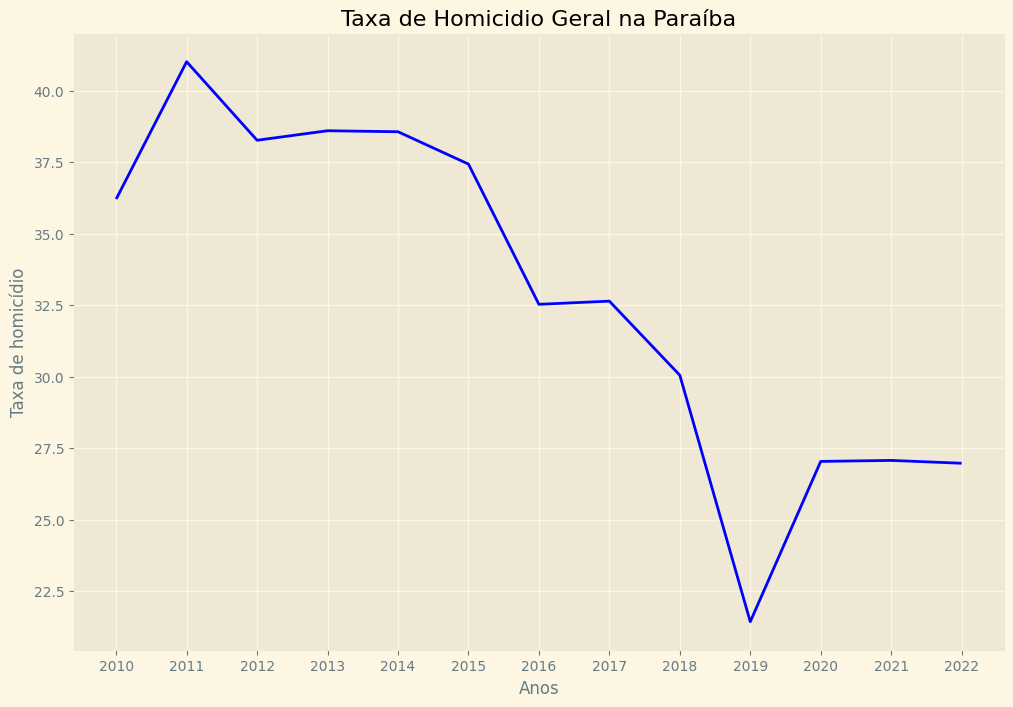

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(hom['ANO'], hom['TAXA'], label='Homicídio', color='blue')
#plt.plot(hom_esc['ANO'], hom_esc['TAXA'], label='Homicídio (baixa escolaridade)', color='red')

plt.xticks(hom['ANO'])

# Adicionar título e rótulos
plt.title('Taxa de Homicidio Geral na Paraíba')
plt.xlabel('Anos')
plt.ylabel('Taxa de homicídio')

# Adicionar legenda
#plt.legend()

plt.style.use('Solarize_Light2')

plt.show()

<Axes: xlabel='ANO'>

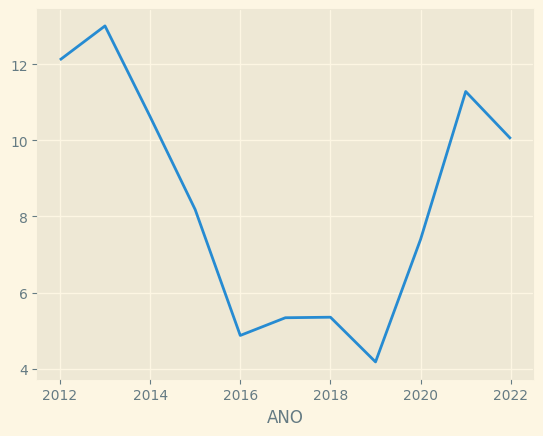

In [54]:
hom_esc.groupby('ANO')['TAXA'].sum().plot()

In [23]:
hom = hom.astype({'ANO': int})
hom_esc = hom_esc.dropna().astype({'ANO': int})

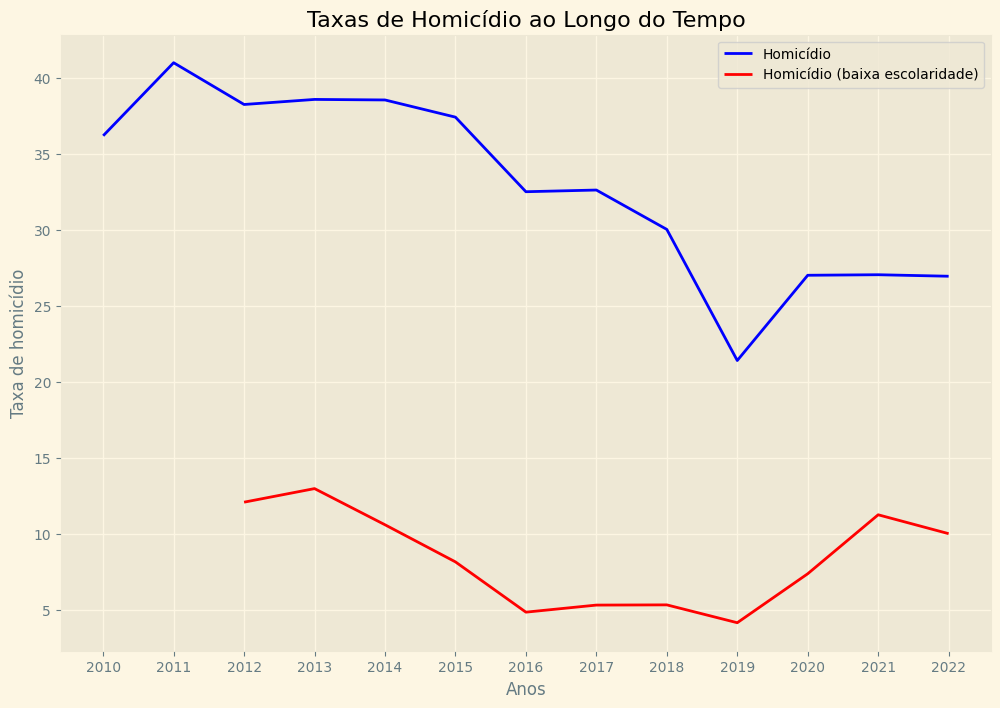

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(hom['ANO'], hom['TAXA'], label='Homicídio', color='blue')
plt.plot(hom_esc['ANO'], hom_esc['TAXA'], label='Homicídio (baixa escolaridade)', color='red')

plt.xticks(hom['ANO'])

# Adicionar título e rótulos
plt.title('Taxas de Homicídio ao Longo do Tempo')
plt.xlabel('Anos')
plt.ylabel('Taxa de homicídio')

# Adicionar legenda
plt.legend()

plt.style.use('Solarize_Light2')

plt.show()

Percebe-se uma diferença de dispersão das taxas a partir do desvio-padrão, onde a taxa de homicídio total tem um desvio-padrão de 6,025 e a taxa de homicídio com baixa escolaridade é de 3.174

In [25]:
hom.std()

ANO               3.894440
HOMICIDIOS      216.241437
POPULACAO     97568.962984
TAXA              6.015737
dtype: float64

In [26]:
hom_esc.std()

ANO               3.316625
HOMICIDIOS      122.706153
POPULACAO     68483.445439
TAXA              3.174523
dtype: float64

In [27]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [28]:
hom

,ANO,HOMICIDIOS,POPULACAO,TAXA
0,2010,1364,3766834,36.211
1,2011,1555,3791315,41.015
2,2012,1460,3815171,38.268
3,2013,1511,3914421,38.601
4,2014,1521,3943885,38.566
5,2015,1487,3972202,37.435
6,2016,1301,3999415,32.530
7,2017,1314,4025558,32.641
8,2018,1201,3996496,30.051
9,2019,861,4018127,21.428


In [29]:
std_hom = hom.filter(['HOMICIDIOS', 'TAXA'])['TAXA'].std()

# Lendo dados do IPEA para comparação

In [30]:
taxa_ipea = pd.read_csv('data/taxa-homicidios-2010-01--01-2022-01--01.csv', sep=';').rename(columns={'período': 'ANO', 'valor': 'TAXA'}).filter(['ANO', 'TAXA'])
std_ipea = taxa_ipea['TAXA'].std()

round(abs(std_hom - std_ipea), 3)

np.float64(0.106)

# Analisando dados pela escolaridade

In [31]:
dist_esc = df_hom.groupby('ESC2010')['CONTADOR'].count()
dist_esc

ESC2010
0.0     335
1.0    2009
2.0    1319
3.0     505
4.0      43
5.0      85
9.0    4353
Name: CONTADOR, dtype: int64

In [32]:
df_hom_base # filtrando por educação basica (ef1, ef2, em)

,DTOBITO,CONTADOR,OCUP,HORAOBITO,NATURAL,CODMUNNATU,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC2010,CODMUNRES,LOCOCOR,CODMUNOCOR,CIRCOBITO,FONTE,TIPOBITO
2920,2012,1429,621005,0510,NaN,NaN,20021977,435,1,4,1,2.0,251680,5,292400,3,1,2
2933,2012,1484,NaN,2230,NaN,NaN,10021987,424,1,4,1,1.0,251010,4,251010,3,NaN,2
2934,2012,1487,717020,2300,NaN,NaN,01061979,432,1,4,5,1.0,250400,4,250400,3,NaN,2
2937,2012,1490,622020,NaN,NaN,NaN,10091990,421,1,1,1,3.0,251510,5,251510,3,NaN,2
2947,2012,1639,622020,NaN,NaN,NaN,03071995,416,1,4,9,2.0,250760,4,250760,3,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16818,2022,1534790,NaN,1800,825,251370,15022000,422,1,4,1,2.0,251370,5,250750,3,1,2
16821,2022,1534796,NaN,0100,825,250750,21111994,427,1,4,1,2.0,250180,4,250180,3,1,2
16828,2022,1539848,NaN,0500,826,260765,04071977,445,2,4,1,1.0,251370,4,251370,3,1,2
16835,2022,1541331,NaN,NaN,827,270350,13061983,439,2,4,1,2.0,251370,5,251370,3,NaN,2


Verificando de acordo com as informações de identificação e comparando (raça, idade, situação conjugal, etc.)

idade

In [33]:
df_hom_base = df_hom_base.query('IDADE.str.startswith("4")') # filtrando por idade em anos e eliminando os que tem 999 ou bebês
df_hom_base['IDADE'] = df_hom_base['IDADE'].str[1:]

df_hom = df_hom.query('IDADE.str.startswith("4")') # filtrando por idade em anos e eliminando os que tem 999 ou bebês
df_hom['IDADE'] = df_hom['IDADE'].str[1:]

/tmp/ipykernel_61288/1998605032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hom_base['IDADE'] = df_hom_base['IDADE'].str[1:]


6 a 10 anos -> fundamental 1

11 a 14 anos -> fundamental 2

15 a 17 anos -> medio

lei de diretrizes

In [34]:
df_hom = df_hom.astype({'IDADE': int})
df_hom_base = df_hom_base.astype({'IDADE': int})

# não temos o dado da escolaridade que está cursando, portanto pegamos a próxima fase, que indica baixa escolaridade

# para fundamental 1:
df_hom_base.query('IDADE > 10 and IDADE <= 18 and ESC2010 <= 0')

# para fundamental 2:
df_hom_base.query('IDADE > 14 and IDADE <= 18 and ESC2010 <= 1')

# para medio:
# grupo 1 -> 18-24
df_hom_base_18_total = df_hom.query('18 <= IDADE <= 24')['IDADE'].count()
df_hom_base_18 = df_hom_base.query('18 <= IDADE <= 24 and ESC2010 <= 2')['IDADE'].count() # 1088 casos

# grupo 2 -> 25-34
df_hom_base_25_total = df_hom.query('25 <= IDADE <= 34')['IDADE'].count()
df_hom_base_25 = df_hom_base.query('25 <= IDADE <= 34 and ESC2010 <= 2')['IDADE'].count() # 1084

# grupo 3 -> 35-44
df_hom_base_35_total = df_hom.query('35 <= IDADE <= 44')['IDADE'].count()
df_hom_base_35 = df_hom_base.query('35 <= IDADE <= 44 and ESC2010 <= 2')['IDADE'].count() # 581

# grupo 4 -> 45-54
df_hom_base_45_total = df_hom.query('45 <= IDADE <= 54')['IDADE'].count()
df_hom_base_45 = df_hom_base.query('45 <= IDADE <= 54 and ESC2010 <= 2')['IDADE'].count() # 267

# grupo 5 -> 55-64
df_hom_base_55_total = df_hom.query('55 <= IDADE <= 64')['IDADE'].count()
df_hom_base_55 = df_hom_base.query('55 <= IDADE <= 64 and ESC2010 <= 2')['IDADE'].count() # 114

# grupo 6 -> 65 =>
df_hom_base_65_total = df_hom.query('IDADE >= 65')['IDADE'].count()
df_hom_base_65 = df_hom_base.query('IDADE >= 65 and ESC2010 <= 2')['IDADE'].count() # 62

In [35]:
df_hom.query('18 <= IDADE <= 24')

,DTOBITO,CONTADOR,OCUP,HORAOBITO,NATURAL,CODMUNNATU,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC2010,CODMUNRES,LOCOCOR,CODMUNOCOR,CIRCOBITO,FONTE,TIPOBITO
1,2010,205,622020,1700,825,NaN,02021987,23,1,4,2,NaN,250560,4,251450,3,9,2
15,2010,2143,768320,2100,NaN,NaN,27071990,20,1,4,1,NaN,251080,5,251080,3,1,2
18,2010,2625,NaN,NaN,825,NaN,31101991,18,1,4,9,NaN,250630,5,250630,3,1,2
19,2010,2627,NaN,0700,825,NaN,NaN,21,1,4,1,NaN,250600,5,250600,3,1,2
20,2010,3025,NaN,1620,NaN,NaN,28021987,22,1,4,1,NaN,250240,4,251380,3,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16826,2022,1535498,914405,2125,825,250750,23102001,20,1,4,NaN,NaN,250750,1,250750,3,NaN,2
16829,2022,1539850,NaN,NaN,825,250750,16022003,19,2,4,9,9.0,250730,5,250730,3,1,2
16830,2022,1539852,NaN,1930,825,250750,14052002,20,1,4,1,NaN,250750,4,250750,3,NaN,2
16832,2022,1540588,NaN,1540,825,251290,28031999,23,1,4,1,NaN,250140,4,250140,3,1,2


In [36]:
df_hom_base_18_taxa = df_hom_base_18/df_hom_base_18_total
df_hom_base_25_taxa = df_hom_base_25/df_hom_base_25_total
df_hom_base_35_taxa = df_hom_base_35/df_hom_base_35_total
df_hom_base_45_taxa = df_hom_base_45/df_hom_base_45_total
df_hom_base_55_taxa = df_hom_base_55/df_hom_base_55_total
df_hom_base_65_taxa = df_hom_base_65/df_hom_base_65_total

In [37]:
idade_series = pd.Series({'18-25': df_hom_base_18, '25-35': df_hom_base_25, '35-45': df_hom_base_35, '45-55': df_hom_base_45, '55-65': df_hom_base_55,'65+': df_hom_base_65})

In [83]:
idade_series_taxa = pd.Series({'18-25': df_hom_base_18_taxa, '25-35': df_hom_base_25_taxa, '35-45': df_hom_base_35_taxa, '45-55': df_hom_base_45_taxa, '55-65': df_hom_base_55_taxa,'65+': df_hom_base_65_taxa})

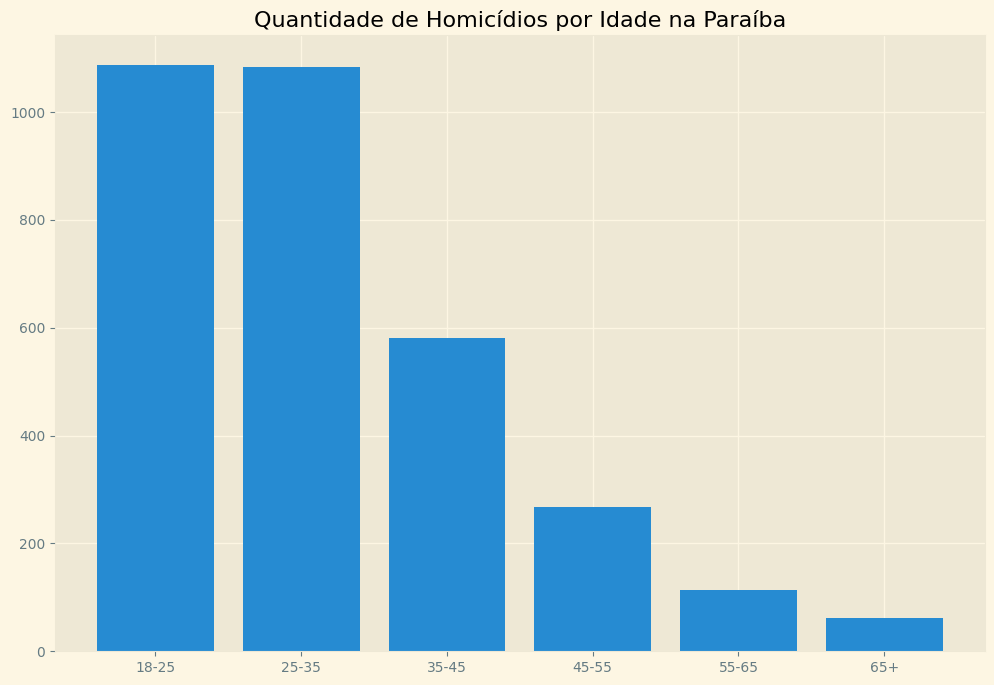

In [115]:
plt.figure(figsize=(12,8))
plt.bar(idade_series.index, idade_series)

plt.title('Quantidade de Homicídios por Idade na Paraíba')

plt.show()

#idade_series.plot(kind='bar') # a maior parte das vitimas tem entre 18-35 anos

In [84]:
idade_series_taxa = round(idade_series_taxa * 100, 2)

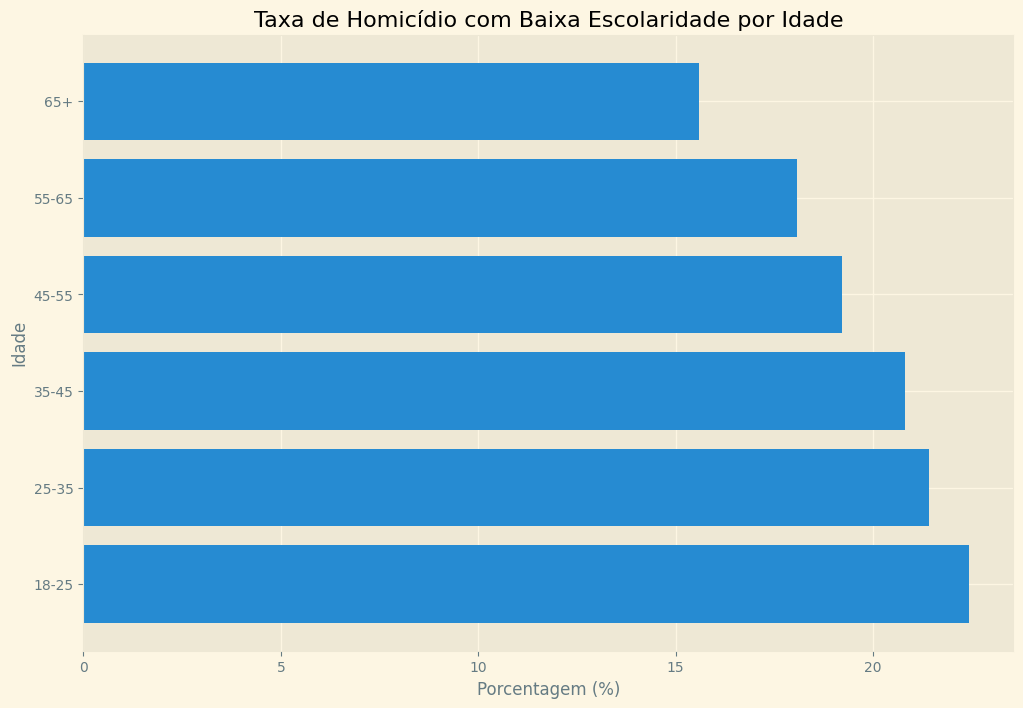

In [116]:
plt.figure(figsize=(12,8))

plt.barh(idade_series_taxa.index, idade_series_taxa)

plt.title('Taxa de Homicídio com Baixa Escolaridade por Idade')

plt.ylabel('Idade')
plt.xlabel('Porcentagem (%)')

plt.show()

# idade_series_taxa.plot(kind='bar') # 86.77% aprox.das pessoas de cada faixa etária que morrem tem baixa escolaridade em relação as pessoas que tem ensino base completo
# e aprox. 19.59% das pessoas de cada faixa etária que morrem tem baixa escolaridade em relação ao total de pessoas.

# não tem uma idade que influencia a partir da baixa escolaridade, mantendo-a praticamente constante com um desvio-padrão de 0,025 no de baixa escolaridade em relação ao total de pessoas.

probabilidade de uma pessoa ter baixa escolaridade

In [41]:
round((df_hom.query('ESC2010 <= 2').groupby('ESC2010', dropna=False)['DTOBITO'].count().sum()/df_hom.groupby('ESC2010', dropna=False)['DTOBITO'].count().sum())*100, 2)

np.float64(21.81)

raça (rever com baixa escolaridade ESC2010 <= 2)

In [ ]:
df_hom_base_raca = df_hom_base['RACACOR'].replace('999', nan).dropna().reset_index().drop('index', axis=1)
total = df_hom_base_raca.groupby('RACACOR')['RACACOR'].count().sum()

plt.bar(df_hom_base_raca.groupby('RACACOR')['RACACOR'].count().apply(lambda x: round((x/total) * 100, 2)))

#.plot(kind='bar', figsize=(10, 6))

# pardas (4) --- 89,47%
# brancas (1) --- 6,82%
# pretas (2) --- 3,56%

In [120]:
racas = pd.DataFrame({'Taxa': ['89,47%', '6,82%', '3,56%']}, index=['Pardas', 'Brancas', 'Pretas'])
display(racas)

,Taxa
Pardas,"89,47%"
Brancas,"6,82%"
Pretas,"3,56%"


<Axes: xlabel='Raça', ylabel='Homicídios'>

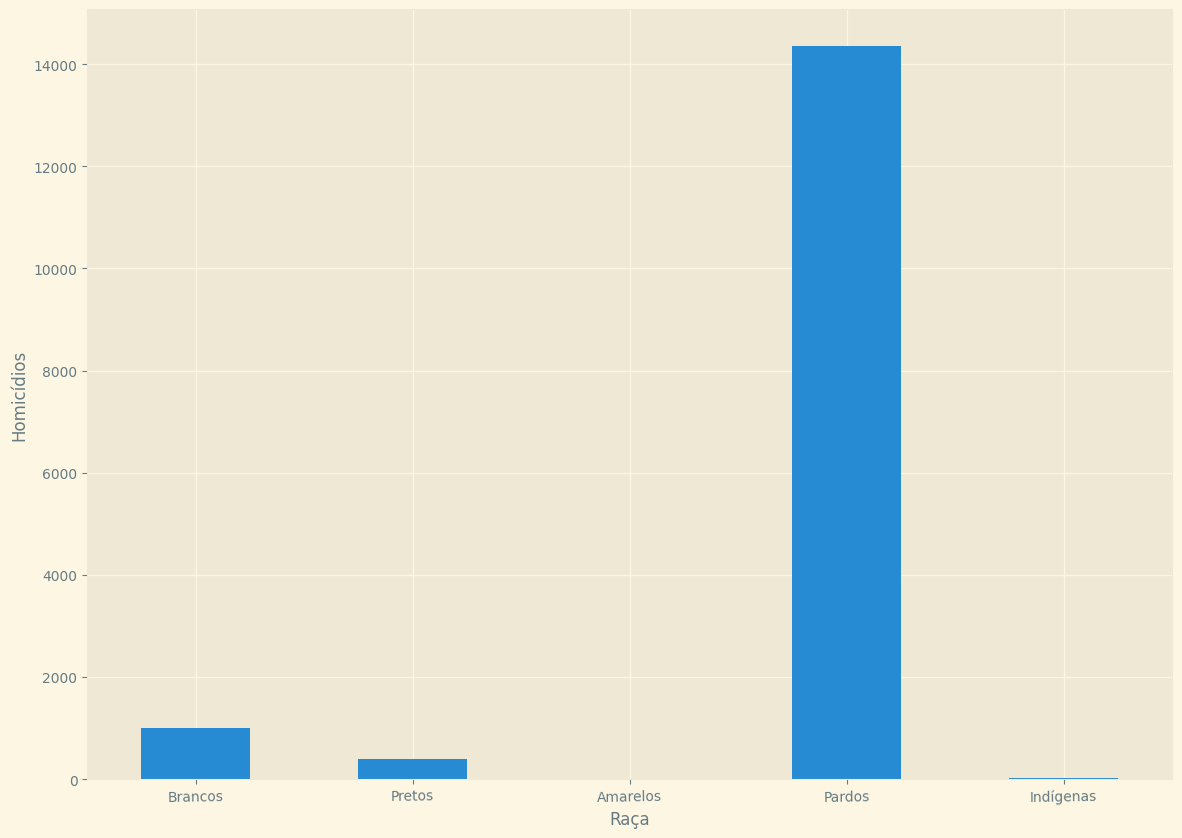

In [106]:
df_hom.groupby('RACACOR')['RACACOR'].count().rename({'1': 'Brancos', '2': 'Pretos', '3': 'Amarelos', '4': 'Pardos', '5': 'Indígenas'}).plot(
    kind='bar', figsize=(14, 10), xlabel='Raça', ylabel='Homicídios', rot=True)

gênero

In [44]:
total = df_hom_base.groupby('SEXO')['SEXO'].count().sum()
df_hom_base.groupby('SEXO')['SEXO'].count().apply(lambda x: round((x/total) * 100, 2))#.plot(kind='bar')

# 92,56% dos casos de baixa escolaridade são homens
# 7,44% dos casos de baixa escolaridade são mulheres

SEXO
1    92.56
2     7.44
Name: SEXO, dtype: float64

ocupação

In [45]:
df_hom_base.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).head(20)

# geral

# top 1 -> agropecuária (trabalhador rural)
# top 2 -> não identificado (trabalhador terciário)
# top 3 -> servente de obras
# top 4 -> pedreiro
# top 5 -> comerciante varejista

# baixa escolaridade

# top 1 -> não identificado (trabalhador terciário)
# top 2 -> agropecuária (trabalhador rural)
# top 3 -> servente de obras
# top 4 -> caseiro (agricultura)
# top 5 -> pedreiro

OCUP
999991    383
622020    353
717020    170
622005    133
715210    106
354705     80
141410     71
517330     48
999992     47
524305     37
999993     36
716610     35
914405     35
512105     30
782305     30
999994     28
631210     19
517420     18
521110     18
621005     15
Name: DTOBITO, dtype: int64

In [46]:
total = df_hom.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).sum()
len(df_hom.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).unique()) #.apply(lambda x: round((x/total) * 100, 2))#.head(20)

total_base = df_hom_base.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).sum()
len(df_hom_base.groupby('OCUP')['DTOBITO'].count().sort_values(ascending=False).unique()) #.apply(lambda x: round((x/total_base) * 100, 2)).head(20)

# quem trabalha como rural, no total (tendo em) -> 26.11% 1600
# tendo somente ensino base -> 17.26% 380

# quem trabalha como autônomo, no total (tendo em) -> 11.98%
# tendo somente ensino base -> 18.73%

30

Quem tem baixa escolaridade, normalmente trabalha no rural ou é autônomo. Além disso tem menos oportunidades de carreira.

# Encontrando um perfil das vítimas

In [47]:
# Achando o perfil das principais vítimas de homicídio no estado da Paraíba

hom_perfil = df_hom.query('ESC2010 == 1') # 21.20% das vítimas possuiam no máximo o Ensino Fundamental 1

perfil_18 = hom_perfil.query('18 <= IDADE <= 24')['IDADE'].count() # 553
perfil_25 = hom_perfil.query('25 <= IDADE <= 34')['IDADE'].count() # 623
perfil_35 = hom_perfil.query('35 <= IDADE <= 44')['IDADE'].count() # 340
perfil_45 = hom_perfil.query('45 <= IDADE <= 54')['IDADE'].count() # 173
perfil_55 = hom_perfil.query('55 <= IDADE <= 64')['IDADE'].count() # 74
perfil_65 = hom_perfil.query('IDADE >= 65')['IDADE'].count() # 33

hom_perfil = hom_perfil.query('25 <= IDADE <= 34')
total = hom_perfil.groupby('RACACOR')['RACACOR'].count().sum()
hom_perfil.groupby('RACACOR')['RACACOR'].count().apply(lambda x: round((x/total) * 100, 2)) # 90.24% das vítimas são pardas

hom_perfil = hom_perfil.query('RACACOR == "4"')
total = hom_perfil.groupby('SEXO')['SEXO'].count().sum()
hom_perfil.groupby('SEXO')['SEXO'].count().apply(lambda x: round((x/total) * 100, 2)) # 94.12% das vítimas são homens

hom_perfil.groupby('OCUP')['DTOBITO'].count().apply(lambda x: round((x/total) * 100, 2)).sort_values(ascending=False)
# 11.39% se enquadra no código 622020 da Classificação Brasileira de Ocupações, Trabalhador volante da agricultura

# Maior parte das vítimas possui até o Ensino Fundamental 1, na faixa etária de 25 a 35 anos, são homens pardos, que trabalham na área rural

OCUP
622020    11.39
717020     6.45
622005     5.12
715210     3.23
141410     1.90
354705     1.52
999992     1.52
914405     1.33
999994     0.95
517330     0.95
521110     0.76
716610     0.76
782305     0.76
517420     0.57
999993     0.57
519205     0.57
999991     0.57
512105     0.38
519935     0.38
771105     0.38
631105     0.38
716525     0.38
524305     0.38
517410     0.38
517310     0.38
516110     0.19
111415     0.19
141405     0.19
313130     0.19
321110     0.19
354605     0.19
514215     0.19
513205     0.19
723310     0.19
524205     0.19
521135     0.19
715615     0.19
715505     0.19
724440     0.19
782505     0.19
782315     0.19
775120     0.19
761303     0.19
724315     0.19
992115     0.19
828110     0.19
848505     0.19
Name: DTOBITO, dtype: float64

Maior parte das vítimas possui até o Ensino Fundamental 1, na faixa etária de 25 a 35 anos, são homens pardos, que trabalham na área rural

Em relação à raça, observamos que houve um aumento de 0,77% quando são pardos dentro do perfil que mais sofre homicídios, ao invés de apenas pardos.

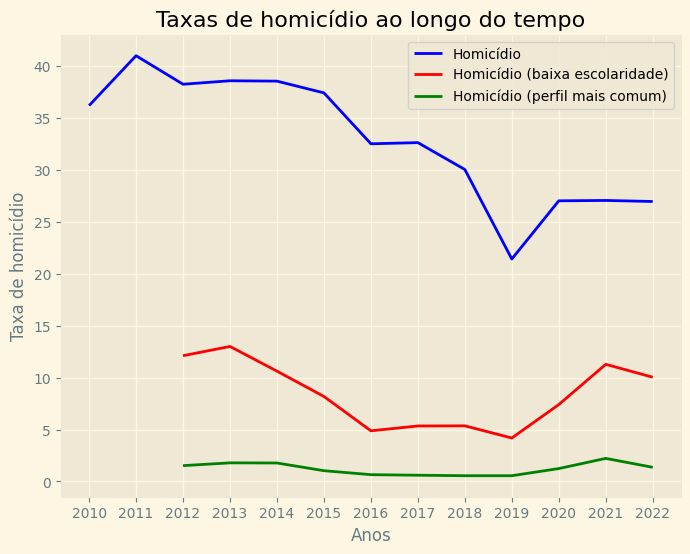

In [48]:
import matplotlib.pyplot as plt

hom_perfil = (hom_perfil
 .groupby('DTOBITO')['CONTADOR']
 .count()
 .reset_index()
 .merge(pop_esc, left_index=True, right_index=True, how='inner')
 .drop('DTOBITO_y', axis=1)
 .rename({'DTOBITO_x': 'ANO', 'CONTADOR': 'HOMICIDIOS'}, axis=1)
 .assign(TAXA=lambda x: round((x['HOMICIDIOS']/x['POPULACAO']) * 100000, 3))
 .astype({'ANO': int})
)

plt.figure(figsize=(8, 6))
plt.plot(hom['ANO'], hom['TAXA'], label='Homicídio', color='blue')
plt.plot(hom_esc['ANO'], hom_esc['TAXA'], label='Homicídio (baixa escolaridade)', color='red')
plt.plot(hom_perfil['ANO'], hom_perfil['TAXA'], label='Homicídio (perfil mais comum)', color='green')

plt.xticks(hom['ANO'])

# Adicionar título e rótulos
plt.title('Taxas de homicídio ao longo do tempo')
plt.xlabel('Anos')
plt.ylabel('Taxa de homicídio')

# Adicionar legenda
plt.legend()

plt.style.use('Solarize_Light2')

plt.show()

Analisando o período de 2016-2019, verificamos que a taxa de homicídio total teve uma queda, enquanto que as taxas de homicídio (baixa escolaridade) e homicídio (perfil mais comum) se mantiveram praticamente constantes. Verificamos isso através do desvio-padrão, onde nesse período selecionado de 2016 a 2019, a taxa total teve um desvio-padrão de 5,399, enquanto que a de baixa escolaridade teve um desvio-padrão de 0,552 e a do perfil mais comum teve 0,048, ou seja, uma diferença de aproximadamente 100x na variação desse período. Isso mostra que, mesmo variando bastante a taxa de homicídio ao longo dos anos, o perfil mais comum permaneceu com uma taxa de homicídio praticamente constante.

Analisando o período total, essa diferença cai para 8x, como analisado na última tabela.

Quanto mais dentro do perfil mais comum, mais constante é a quantidade de mortes.

In [49]:
anos = [2016,2017,2018,2019]

df_std = pd.DataFrame({'Desvio-padrão': [hom.query('ANO in @anos')['TAXA'].std(),
                                         hom_esc.query('ANO in @anos')['TAXA'].std(),
                                         hom_perfil.query('ANO in @anos')['TAXA'].std()]},
                                         index=['Taxa Total', 'Baixa Escolaridade', 'Perfil Mais Comum'])

df_std

,Desvio-padrão
Taxa Total,5.293138
Baixa Escolaridade,0.551722
Perfil Mais Comum,0.048083


In [50]:
df_std = pd.DataFrame({'Desvio-padrão': [hom['TAXA'].std(),
                                         hom_esc['TAXA'].std(),
                                         hom_perfil['TAXA'].std()]},
                                         index=['Taxa Total', 'Baixa Escolaridade', 'Perfil Mais Comum'])

df_std

,Desvio-padrão
Taxa Total,6.015737
Baixa Escolaridade,3.174523
Perfil Mais Comum,0.581588


In [51]:
import pandas as pd

metricas = pd.DataFrame({'Métricas analisadas': ['ANO', 'HOMICÍDIOS', 'POPULAÇÃO', 
                                                 'IDADE', 'SEXO', 'RAÇA', 'OCUPAÇÃO',
                                                 'ESCOLARIDADE']})
metricas

,Métricas analisadas
0,ANO
1,HOMICÍDIOS
2,POPULAÇÃO
3,IDADE
4,SEXO
5,RAÇA
6,OCUPAÇÃO
7,ESCOLARIDADE


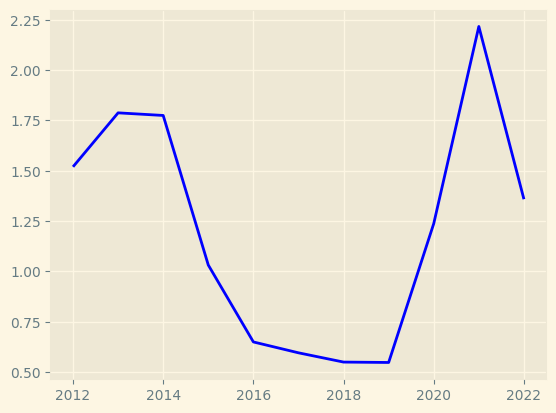

In [52]:

plt.plot(hom_perfil['ANO'], hom_perfil['TAXA'], label='Homicídio', color='blue')
#plt.plot(hom['ANO'], hom['HOMICIDIOS'], label='Homicídio', color='blue')

